PSNR: 30.490350314492908
PSNR cropped: 30.90972077751489


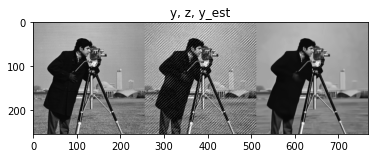

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from bm3d import bm3d
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.signal import fftconvolve
from bm3d import gaussian_kernel
import enum

class BM3DStages(enum.Enum):
    HARD_THRESHOLDING = 1
    WIENER_FILTERING = 2  # Pass a hard-thresholding estimate to the function instead of WIENER_FILTERING only
    ALL_STAGES = HARD_THRESHOLDING + WIENER_FILTERING

class BM3DProfile:
    """
    BM3DProfile object, containing the default settings for BM3D.
    Default values for our profile = 'np'
    """

    print_info = False

    # Transforms used
    transform_2d_ht_name = 'bior1.5'
    transform_2d_wiener_name = 'dct'
    transform_3rd_dim_name = 'haar'

    # -- Exact variances for correlated noise: --

    # Variance calculation parameters
    nf = 32  # domain size for FFT computations
    k = 4  # how many layers of var3D to calculate

    # Refiltering
    denoise_residual = False  # Perform residual thresholding and re-denoising
    residual_thr = 3  # Threshold for the residual HT (times sqrt(PSD))
    max_pad_size = None  # Maximum required pad size (= half of the kernel size), or 0 -> use image size

    # Block matching
    gamma = 3.0  # Block matching correction factor

    # -- Classic BM3D for correlated noise --

    # Hard-thresholding (HT) parameters:
    bs_ht = 8  # N1 x N1 is the block size used for the hard-thresholding (HT) filtering
    step_ht = 3  # sliding step to process every next reference block
    max_3d_size_ht = 16  # maximum number of similar blocks (maximum size of the 3rd dimension of a 3D array)
    search_window_ht = 39  # side length of the search neighborhood for full-search block-matching (BM), must be odd
    tau_match = 3000  # threshold for the block-distance (d-distance)

    # None in these parameters results in automatic parameter selection for them
    lambda_thr3d = None  # 2.7  # threshold parameter for the hard-thresholding in 3D transform domain
    mu2 = None  # 1.0
    # Refilter
    lambda_thr3d_re = None
    mu2_re = None
    beta = 2.0  # parameter of the 2D Kaiser window used in the reconstruction

    # Wiener filtering parameters:
    bs_wiener = 8
    step_wiener = 3
    max_3d_size_wiener = 32
    search_window_wiener = 39
    tau_match_wiener = 400
    beta_wiener = 2.0
    dec_level = 0  # dec. levels of the dyadic wavelet 2D transform for blocks
    #  (0 means full decomposition, higher values decrease the dec. number)

    def get_block_size(self, mode: BM3DStages) -> int:
        """
        Get block size parameter.
        :param mode: BM3DStages enum value
        :return: block size
        """
        if mode == BM3DStages.HARD_THRESHOLDING or mode == BM3DStages.ALL_STAGES:
            return self.bs_ht
        else:
            return self.bs_wiener

    def get_step_size(self, mode: BM3DStages) -> int:
        """
        Get step size parameter.
        :param mode: BM3DStages enum value
        :return: step size
        """
        if mode == BM3DStages.HARD_THRESHOLDING or mode == BM3DStages.ALL_STAGES:
            return self.step_ht
        else:
            return self.step_wiener

    def get_max_3d_size(self, mode: BM3DStages) -> int:
        """
        Get maximum stack size in the 3rd dimension.
        :param mode: BM3DStages enum value
        :return: maximum stack size in the 3rd dimension
        """
        if mode == BM3DStages.HARD_THRESHOLDING or mode == BM3DStages.ALL_STAGES:
            return self.max_3d_size_ht
        else:
            return self.max_3d_size_wiener

    def get_search_window(self, mode: BM3DStages) -> int:
        """
        Get search window size parameter.
        :param mode: BM3DStages enum value
        :return: search window size
        """
        if mode == BM3DStages.HARD_THRESHOLDING or mode == BM3DStages.ALL_STAGES:
            return self.search_window_ht
        else:
            return self.search_window_wiener

    def get_block_threshold(self, mode: BM3DStages) -> int:
        """
        Get block matching threshold parameter.
        :param mode: BM3DStages enum value
        :return: block matching threshold
        """
        if mode == BM3DStages.HARD_THRESHOLDING or mode == BM3DStages.ALL_STAGES:
            return self.tau_match
        else:
            return self.tau_match_wiener

        
def get_psnr(y_est: np.ndarray, y_ref: np.ndarray) -> float:
    """
    Return PSNR value for y_est and y_ref presuming the noise-free maximum is 1.
    :param y_est: Estimate array
    :param y_ref: Noise-free reference
    :return: PSNR value
    """
    return 10 * np.log10(1 / np.mean(((y_est - y_ref).ravel()) ** 2))


def get_cropped_psnr(y_est: np.ndarray, y_ref: np.ndarray, crop: tuple) -> float:
    """
    Return PSNR value for y_est and y_ref presuming the noise-free maximum is 1.
    Crop the images before calculating the value by crop.
    :param y_est: Estimate array
    :param y_ref: Noise-free reference
    :param crop: Tuple of crop-x and crop-y from both stides
    :return: PSNR value
    """
    return get_psnr(np.atleast_3d(y_est)[crop[0]:-crop[0], crop[1]:-crop[1], :],
                    np.atleast_3d(y_ref)[crop[0]:-crop[0], crop[1]:-crop[1], :])


def get_experiment_kernel(noise_type: str, noise_var: float, sz: tuple = np.array((101, 101))):
    """
    Get kernel for generating noise from specific experiment from the paper.
    :param noise_type: Noise type string, g[0-4](w|)
    :param noise_var: noise variance
    :param sz: size of image, used only for g4 and g4w
    :return: experiment kernel with the l2-norm equal to variance
    """
    kernel = np.array([[1]])
    noise_types = ['gw', 'g0', 'g1', 'g2', 'g3', 'g4', 'g1w', 'g2w', 'g3w', 'g4w']
    if noise_type not in noise_types:
        raise ValueError("Noise type must be one of " + str(noise_types))

    if noise_type != "g4" and noise_type != "g4w":
        sz = np.array([101, 101])
    else:
        sz = np.array(sz)

    # Sizes for meshgrids
    sz2 = -(1 - (sz % 2)) * 1 + np.floor(sz / 2)
    sz1 = np.floor(sz / 2)
    uu, vv = np.meshgrid([i for i in range(-int(sz1[0]), int(sz2[0]) + 1)],
                         [i for i in range(-int(sz1[1]), int(sz2[1]) + 1)])

    beta = 0.8

    if noise_type[0:2] == 'g1':
        # Horizontal line
        kernel = np.atleast_2d(16 - abs(np.linspace(1, 31, 31) - 16))

    elif noise_type[0:2] == 'g2':
        # Circular repeating pattern
        scale = 1
        dist = uu ** 2 + vv ** 2
        kernel = np.cos(np.sqrt(dist) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g3':
        # Diagonal line pattern kernel
        scale = 1
        kernel = np.cos((uu + vv) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g4':
        # Pink noise
        dist = uu ** 2 + vv ** 2
        n = sz[0] * sz[1]
        spec = (np.sqrt((np.sqrt(n) * 1e-2) / (np.sqrt(dist) + np.sqrt(n) * 1e-2)))
        kernel = fftshift(ifft2(ifftshift(spec)))

    else:  # gw and g0 are white
        beta = 0

    # -- Noise with additional white component --

    if len(noise_type) > 2 and noise_type[2] == 'w':
        kernel = kernel / np.sqrt(np.sum(kernel ** 2))
        kalpha = np.sqrt((1 - beta) + beta * abs(fft2(kernel, (sz[0], sz[1]))) ** 2)
        kernel = fftshift(ifft2(kalpha))

    kernel = np.real(kernel)
    # Correct variance
    kernel = kernel / np.sqrt(np.sum(kernel ** 2)) * np.sqrt(noise_var)

    return kernel


def get_experiment_noise(noise_type: str, noise_var: float, realization: int, sz: tuple)\
        -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Generate noise for experiment with specified kernel, variance, seed and size.
    Return noise and relevant parameters.
    The generated noise is non-circular.
    :param noise_type: Noise type, see get_experiment_kernel for list of accepted types.
    :param noise_var: Noise variance of the resulting noise
    :param realization: Seed for the noise realization
    :param sz: image size -> size of resulting noise
    :return: noise, PSD, and kernel
    """
    np.random.seed(realization)

    # Get pre-specified kernel
    kernel = get_experiment_kernel(noise_type, noise_var, sz)

    # Create noisy image
    half_kernel = np.ceil(np.array(kernel.shape) / 2)

    if len(sz) == 3 and half_kernel.size == 2:
        half_kernel = [half_kernel[0], half_kernel[1], 0]
        kernel = np.atleast_3d(kernel)

    half_kernel = np.array(half_kernel, dtype=int)

    # Crop edges
    noise = fftconvolve(np.random.normal(size=(sz + 2 * half_kernel)), kernel, mode='same')
    noise = np.atleast_3d(noise)[half_kernel[0]:-half_kernel[0], half_kernel[1]:-half_kernel[1], :]

    psd = abs(fft2(kernel, (sz[0], sz[1]), axes=(0, 1))) ** 2 * sz[0] * sz[1]

    return noise, psd, kernel



# Experiment specifications
imagename = 'cameraman256.png'

# Load noise-free image
y = np.array(Image.open(imagename)) / 255
# Possible noise types to be generated 'gw', 'g1', 'g2', 'g3', 'g4', 'g1w',
# 'g2w', 'g3w', 'g4w'.
noise_type = 'g3w'
noise_var = 0.01  # Noise variance
seed = 0  # seed for pseudorandom noise realization

# Generate noise with given PSD
noise, psd, kernel = get_experiment_noise(noise_type, noise_var, seed, y.shape)
# N.B.: For the sake of simulating a more realistic acquisition scenario,
# the generated noise is *not* circulant. Therefore there is a slight
# discrepancy between PSD and the actual PSD computed from infinitely many
# realizations of this noise with different seeds.

# Generate noisy image corrupted by additive spatially correlated noise
# with noise power spectrum PSD
z = np.atleast_3d(y) + np.atleast_3d(noise)


# To include refiltering:
y_est = bm3d(z, psd, 'refilter')

# Note: For white noise, you may instead of the PSD also pass a standard deviation
#y_est = bm3d(z, np.sqrt(noise_var));

psnr = get_psnr(y, y_est)
print("PSNR:", psnr)

# PSNR ignoring 16-pixel wide borders (as used in the paper), due to refiltering potentially leaving artifacts
# on the pixels near the boundary of the image when noise is not circulant
psnr_cropped = get_cropped_psnr(y, y_est, [16, 16])
print("PSNR cropped:", psnr_cropped)

# Ignore values outside range for display (or plt gives an error for multichannel input)
y_est = np.minimum(np.maximum(y_est, 0), 1)
z_rang = np.minimum(np.maximum(z, 0), 1)
plt.title("y, z, y_est")
plt.imshow(np.concatenate((y, np.squeeze(z_rang), y_est), axis=1), cmap='gray')
plt.show()